# Transfer Learning: Wiki IMDB Language model for Twitter Text Classifier
# Using FastAI [ULMFit](https://arxiv.org/abs/1801.06146)

Here I will transfer an Language model trained from Wikpedia to IMDB movie reviews.  I'm taking the encoder of this model and training it on a twitter sentiment data set for positive, negative, or neutral tweets.

In [1]:
#install everything you need
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from IPython.display import display,HTML
from fastai.text.all import *

### Load Presaved Dataloaders([WikiText-103](https://paperswithcode.com/dataset/wikitext-103) transferred to IMDB) Object From My  [Last Project](https://github.com/daveramseymusic/homophobic_speech_classifier_draft/blob/main/homophobic_speech_classifier_2.ipynb):

In [2]:
## to reload simply 
dls_lm = torch.load('dls_lm_imdb.pkl')

In [3]:
# Show what's in the dataloaders 
dls_lm.show_batch(max_n=2)

,text,text_
0,xxbos xxmaj this was the third remake of xxup sleeping xxup with xxup the xxup xxunk xxmaj after xxup xxunk ) and xxup xxunk ) \n\n xxup xxunk was the only one which worked and was a better film \n\n,xxmaj this was the third remake of xxup sleeping xxup with xxup the xxup xxunk xxmaj after xxup xxunk ) and xxup xxunk ) \n\n xxup xxunk was the only one which worked and was a better film \n\n xxup
1,"want and film it ! "" xxmaj no . \n\n xxmaj waters should n't be proud of this mess , fans of waters should n't watch it , its useless , that is , without any use . \n\n xxmaj","and film it ! "" xxmaj no . \n\n xxmaj waters should n't be proud of this mess , fans of waters should n't watch it , its useless , that is , without any use . \n\n xxmaj its"


In [4]:
# instantiate a learner
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

## From LM to Classifier

### Creating the Classifier DataLoaders

In [5]:
#save your path object
path = Path('/notebooks/clean')

Clean up your twitter df

In [21]:
# move the file using bash
mv /notebooks/tweets_sentiment_kaggle.csv /notebooks/clean/

In [7]:
#read csv:  use ISO encoding instead of standard UTF-8
df = pd.read_csv('tweets_sentiment_kaggle.csv', encoding='ISO-8859-1', low_memory=False)

In [ ]:
#read csv:  use ISO encoding instead of standard UTF-8
df = pd.read_csv('tweets_sentiment_kaggle.csv', encoding='ISO-8859-1', low_memory=False)
cols = df.columns #save colnames to variable
#change the first colname to 'label' and the last to 'comment_text'
cols = ['label', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY',
       '_TheSpecialOne_',
       'comment_text']
df.columns = cols #rename all colnames
df = df[['comment_text', 'label']]  #slice df
df.head()

In [10]:
cols = df.columns
cols

Index(['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY',
       '_TheSpecialOne_',
       '@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D'],
      dtype='object')

In [11]:
#change the first colname to 'label' and the last to 'comment_text'
cols = ['label', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY',
       '_TheSpecialOne_',
       'comment_text']
df.columns = cols

In [12]:
df = df[['comment_text', 'label']]
df.head()

,comment_text,label
0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,0
1,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,0
2,my whole body feels itchy and like its on fire,0
3,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",0
4,@Kwesidei not the whole crew,0


In [13]:
# create classifier dataloaders from df
dls_clas = TextDataLoaders.from_df(df, path=path, valid_pct=0.2, vocab=dls_lm.vocab,
                                   text_col='comment_text', label_col='label',)

/opt/conda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [14]:
dls_clas.show_batch(max_n=3)

,text,category
0,xxbos human shield à ® à ® © à¯?à ® xxunk à ® xxunk ® xxunk ® xxunk ® à ® ° xxunk à ® xxunk ® © à¯?à ® xxunk ? à ® ® à ® xxunk ® ªà ® à ® ¿à ® xxunk ® ® à¯ ? à ® xxunk ® à ® à ® à¯?à ® à ® xxunk ® ¿à ® xxunk ? ( à ® ® xxunk ® xxunk ® xxunk ? à ® xxunk ® à¯?à ® à ® ® à¯ ? ) à ® xxunk ® à ® ° à¯?à ® ªà ® ¾à ® xxunk à ® ªà ® ¾à ® ° à¯?à ® ¤à¯?à ® xxunk à ® xxunk ® ¤à¯ ? à ® à ® xxunk ® xxunk ® xxunk à ® xxunk ® xxunk ® ° à¯?à ® xxunk ® ¿à ® xxunk ® xxunk ? à ®,0
1,xxbos xxup good xxup morning xxup everyone xxrep 3 ! a xxrep 3 h xxup its xxup so xxup early xxup and xxup i m xxup up … . xxup thinking xxup about xxup going xxup to xxup the xxup beach xxup and xxup runing … xxup love xxup that i xxup live xxup so xxup close,4
2,xxbos @misskeribaby xxup brand xxup new xxup single xxup from xxmaj ne - yo 's xxup group xxup xxunk & ' future xxup in xxup you & ' xxup uploaded xxup on xxup myspace - xxup go xxup listen xxrep 3 ! : http : / / xxrep 3 w .myspace.com / fdmonline,4


In [15]:
# save your clasafying dataloaders
torch.save(dls_clas,'dls_clas_imdb_lm_dls_on_twitter.pkl')

In [16]:
# align save the dls_lm.vocab to be tthe same as the classifier vocab
dls_clas.vocab=dls_lm.vocab

In [17]:
# instantiate a text_classifier_learner with the dls_clas
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, 
                                metrics=accuracy).to_fp16()

### Fine-Tuning the Classifier

In [29]:
# load your IMDB LM (30.07% accurate) encoder:
learn.load_encoder('5epoch_imdb_2en3_3007_e') 

SuggestedLRs(valley=0.00010964782268274575)

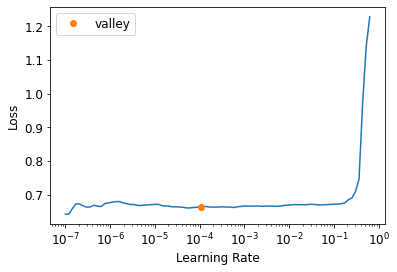

In [30]:
# Find the optimal learning rate
learn.lr_find()

In [31]:
# Run one cycle at the learning rate you decided
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.644545,0.619012,0.655368,09:19


Train the encoder only unfreezing one layer at a time

In [32]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.493524,0.457754,0.780915,10:49


In [33]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.424844,0.393813,0.820265,14:59


In [34]:
#  Save the best model
learn.save('clas_5epoch_imdbtotwitter_n3')

Path('/notebooks/clean/models/clas_5epoch_imdbtotwitter_n3.pth')

In [35]:
# Save the encoder to be trained on other data sets
learn.save_encoder('clas_5epoch_imdbtotwitter_n3_e')

In [36]:
# Attempted to run, but did not save this because it began to overfit and became less accurate
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.402047,0.378020,0.829356,22:29


SuggestedLRs(valley=1.737800812406931e-05)

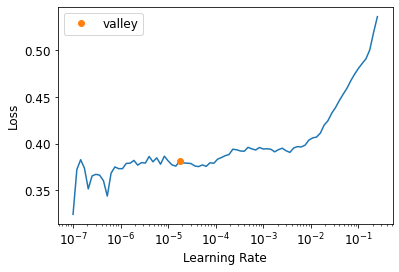

In [44]:
learn.lr_find()

In [45]:
learn.fit_one_cycle(1,1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.384960,0.376700,0.830362,22:27


# The model is now 83% accurate at predicting positive or negative

In [46]:
#  Save the best model
learn.save('clas_7epoch_imdbtotwitter_n3')

Path('/notebooks/clean/models/clas_7epoch_imdbtotwitter_n3.pth')

In [47]:
# Save the encoder to be trained on other data sets
learn.save_encoder('clas_7epoch_imdbtotwitter_n3_e')

In [59]:
!mv models/clas_7epoch_imdbtotwitter_n3.pth models/clas_7epoch_imdbtotwitter_1n5_8300.pth

In [60]:
!mv models/clas_7epoch_imdbtotwitter_n3_e.pth models/clas_7epoch_imdbtotwitter_1en5_8300_e.pth

In [62]:
ls models/

1epoch_twitter_2en3_2331.pth
5epoch_imdb_2en3_3007_e.pth
clas_5epoch_imdbtotwitter_5en3_8293.pth
clas_5epoch_imdbtotwitter_5en3_8293_e.pth
clas_7epoch_imdbtotwitter_1en5_8300_e.pth
clas_7epoch_imdbtotwitter_1n5_8300.pth


### 0=Neg 4=Pos: Test the model with some tweets 

First number: the polarity of the tweet (0 = negative, 4 = positive)

original mean tweet: 'nick jonas was cute back when he was in the jonas brothers.  now he looks like a ferrit'

In [81]:
# test out how good the model is at predicting something you copy and paste from another website
learn.predict('nick jonas was cute back when he was in the jonas brothers.  now he looks like a ferrit')

('4', tensor(1), tensor([0.4754, 0.5246]))

### Adjusted tweets: 

'... and is stupid'

In [82]:
# test out how good the model is at predicting something you copy and paste from another website
learn.predict('nick jonas was super cute back when he was in the jonas brothers.   now he looks like a ferrit and is stupid')

('0', tensor(0), tensor([0.8471, 0.1529]))

'now he looks like a sexy model'

In [87]:
# test out how good the model is at predicting something you copy and paste from another website
learn.predict('nick jonas was super cute back when he was in the jonas brothers.   now he looks like a sexy model')

('4', tensor(1), tensor([0.1630, 0.8370]))

'now he looks horrible'

In [79]:
# test out how good the model is at predicting something you copy and paste from another website
learn.predict('nick jonas was super cute back when he was in the jonas brothers.  now he looks horrible')

('0', tensor(0), tensor([0.9448, 0.0552]))

'now he looks just meh'

In [85]:
# test out how good the model is at predicting something you copy and paste from another website
learn.predict('nick jonas was super cute back when he was in the jonas brothers.  now he looks just meh')

('0', tensor(0), tensor([0.5483, 0.4517]))

### The more you test out the predictor, the more you will see this model is not very good at predicting outside the dataset.  I will update here when I've transfered the model to other data sets.